# Introduction

This notebook is contains an initial analysis of trades generated by Stockie (see https://github.com/frkornet/Stockie for more info). The trades are generated by the program trade.py. 

To be able to run this notebook, you need to have access to two CSV files: train_possible_trades.csv and test_possible_trades.csv. The files are expected to be in the data sub-directory of the current directory. 

The possible trades are generated by using a logistic regression model using a weight of evidence scoring model. The current model uses the following features (function `features` in trade.py):

- MACD_days
- PctDiff_days
- StdDev_days 

where days is 3, 5, 10, 15, 20, 30, 45 or 60. The days indicate on how many past day the feature is based. For example, StdDev_5 means that the feature is calculated using the past 5 days. This results in 24 different features used by the logistic regression model. All the features are derived from the trading day's stock close price.

The regression model uses smoothing to determine the points of local maxima and minima. The smoothing is implemented in function `smooth` in utils.py. The smoothing uses numpy savgol_filter() function the daily close price curve. The local minima and maxima are then determined in trade.py using the numpy argmin and argmax (see function `ticker_trades` for more details. 

The data is collected using the yfinance package. The yfinance package in turn retrieves the data from Yahoo Finance.

The intention is to build a Computation Data Analysis project around improving the performance in generating the possible trades. There are a number of areas that we want to investigate:

1) will performance improve if we add fundamental indicators or technical indicators,  

2) select the best features (for each ML model, see below),

3) will an ensemble of machine learning models improve performance, and

4) will a single stage approach (all trades are generated by an ensemble of models) or a two stage approach (one ensemble generates the possible trades and another ensemble determines which trades to keep/execute).


TODO (to be refined):
- scale the number of symbols down to a suitable subset to enable quick testing (2300+ to 200)
- determine time period to test over. Typically 15  years (split into 10 years for training and 5 years for test). With yfinance we have only 4 years for fundamental data. So, this suggests 3 years training and 1 year testing.
- determine which technical indicators to add to the model and implement them.
- determine which fundamental indicators to add to the model and implement them.
- refine trade.py to ensure that the model is only trained on positive trades in the training dataset.
- build an ensemble of different ML models (logistic regression, random forest trees, SVM) and determine performance
- build a two stage approach by two sets of ML models and ensembles






In [1]:
!pwd

/Users/frkornet/CDA/Project/stockie/notebook


In [2]:
# what is the current ../data directory
!ls ../data

actual_0.csv              bak                       stocks202002.csv
actual_10.csv             exclude.csv               test_possible_trades.csv
actual_20.csv             full_possible_trades.csv  ticker_stats.csv
actual_30.csv             negtrades                 train_possible_trades.csv
actual_40.csv             open_buys.csv             yfin


In [3]:
# General imports and reading the possible trades files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv('../data/train_possible_trades.csv')
test_df = pd.read_csv('../data/test_possible_trades.csv')

print(f"Train row count: {len(train_df)}")
print(f"Test  row count: {len(test_df)}")

Train row count: 17272
Test  row count: 9552


In [4]:
min(train_df.buy_date), max(train_df.buy_date)

('2011-05-13', '2019-07-03')

In [5]:
min(test_df.buy_date), max(test_df.buy_date)

('2017-11-29', '2021-02-05')

In [6]:
train_df

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
0,19.30,2011-10-03,1.07,31.81,25.44,2011-11-08,A,26
1,24.23,2012-09-05,0.83,8.58,26.31,2012-09-19,A,10
2,26.94,2013-04-03,0.33,13.66,30.62,2013-05-29,A,39
3,34.88,2014-10-16,0.50,15.54,40.30,2014-11-26,A,29
4,36.65,2015-06-30,0.54,4.97,38.47,2015-07-14,A,9
...,...,...,...,...,...,...,...,...
17267,0.14,2014-05-29,3.06,100.00,0.28,2014-07-01,ZYXI,23
17268,0.10,2014-10-21,2.05,80.00,0.18,2014-12-02,ZYXI,29
17269,0.13,2014-12-23,2.35,38.46,0.18,2015-01-14,ZYXI,14
17270,0.13,2015-03-16,1.37,76.92,0.23,2015-05-14,ZYXI,42


In [7]:
test_df

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
0,65.75,2018-03-22,0.04,6.66,70.13,2018-11-28,A,174
1,62.10,2018-12-21,0.75,11.82,69.44,2019-01-15,A,15
2,66.66,2019-05-15,0.30,7.41,71.60,2019-06-19,A,24
3,68.74,2019-07-17,0.16,5.64,72.62,2019-09-05,A,35
4,72.32,2020-03-10,0.32,18.43,85.65,2020-05-26,A,53
...,...,...,...,...,...,...,...,...
9547,2.77,2018-12-04,0.32,6.50,2.95,2019-01-04,ZYXI,20
9548,7.70,2019-07-15,1.06,27.53,9.82,2019-08-15,ZYXI,23
9549,9.76,2019-08-22,-0.22,-3.69,9.40,2019-09-17,ZYXI,17
9550,9.01,2019-10-30,0.26,21.86,10.98,2020-02-20,ZYXI,76


In [8]:
!ls ../data/yfin/CYBE.csv

../data/yfin/CYBE.csv


In [9]:
hist = pd.read_csv('../data/yfin/A.csv')
hist

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth
0,2011-02-14,29.54,29.81,29.35,29.40,4865300,0.0,0.0,28.141778
1,2011-02-15,29.40,29.54,27.99,28.00,10243200,0.0,0.0,28.172629
2,2011-02-16,28.16,28.62,28.03,28.60,5815400,0.0,0.0,28.203480
3,2011-02-17,28.47,28.88,28.24,28.83,3665200,0.0,0.0,28.234330
4,2011-02-18,28.78,29.07,28.65,28.83,6137600,0.0,0.0,28.265181
...,...,...,...,...,...,...,...,...,...
2512,2021-02-08,123.92,125.74,122.57,123.41,2065300,0.0,0.0,124.406604
2513,2021-02-09,123.41,123.49,122.36,123.24,1988300,0.0,0.0,124.465715
2514,2021-02-10,124.59,125.74,123.88,125.08,1112600,0.0,0.0,124.524825
2515,2021-02-11,125.70,127.26,125.11,126.96,1122200,0.0,0.0,124.583935


In [10]:
hist.index = hist.Date.values
hist

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth
2011-02-14,2011-02-14,29.54,29.81,29.35,29.40,4865300,0.0,0.0,28.141778
2011-02-15,2011-02-15,29.40,29.54,27.99,28.00,10243200,0.0,0.0,28.172629
2011-02-16,2011-02-16,28.16,28.62,28.03,28.60,5815400,0.0,0.0,28.203480
2011-02-17,2011-02-17,28.47,28.88,28.24,28.83,3665200,0.0,0.0,28.234330
2011-02-18,2011-02-18,28.78,29.07,28.65,28.83,6137600,0.0,0.0,28.265181
...,...,...,...,...,...,...,...,...,...
2021-02-08,2021-02-08,123.92,125.74,122.57,123.41,2065300,0.0,0.0,124.406604
2021-02-09,2021-02-09,123.41,123.49,122.36,123.24,1988300,0.0,0.0,124.465715
2021-02-10,2021-02-10,124.59,125.74,123.88,125.08,1112600,0.0,0.0,124.524825
2021-02-11,2021-02-11,125.70,127.26,125.11,126.96,1122200,0.0,0.0,124.583935


The training trades consist of only a limited number of trades in the 1 - 10 days. The test trades contain a much higher ratio of trades. Let's begine by analyzing why that is. We start by looking at the histograms. You can see that the histograms have a different underlying distribution. 

train: 1day_cnt=0 ratio %=0.00
test : 1day_cnt=156 ratio %=1.63


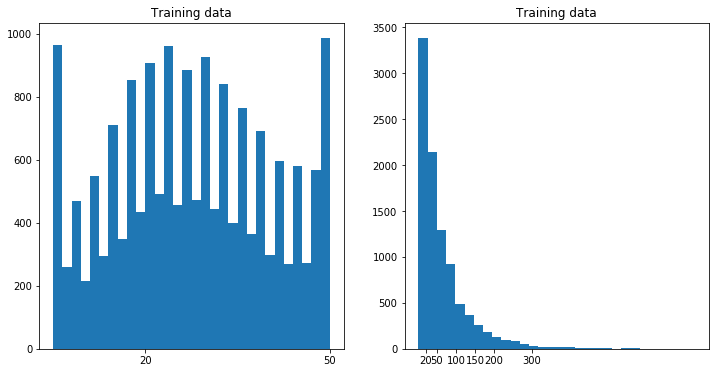

In [11]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.xticks([20, 50, 100, 150, 200, 300])
plt.title("Training data")
train_df.trading_days.hist(bins=30, grid=False)

plt.subplot(1,2,2)
plt.xticks([20, 50, 100, 150, 200, 300])
plt.title("Training data")
test_df.trading_days.hist(bins=30, grid=False)

train_1day_cnt  = train_df.loc[train_df.trading_days == 1].trading_days.count()
train_ratio_1day = (train_1day_cnt / len(train_df))*100
print(f"train: 1day_cnt={train_1day_cnt} ratio %={train_ratio_1day:.2f}")

test_1day_cnt  = test_df.loc[test_df.trading_days == 1].trading_days.count()
test_ratio_1day = ( test_1day_cnt / len(test_df) ) * 100
print(f"test : 1day_cnt={test_1day_cnt} ratio %={test_ratio_1day:.2f}")

Let's refine this by plotting a line chart of trading_days versus row counts, and it will become clear that there is quite a difference. In the training data set you see row count only going up to 600 - 700 around 40 - 50 trading days, while for testing trades it peaks at 1780 with 1 trading days, and then drops quickly down.

[0, 400, 0, 1750]

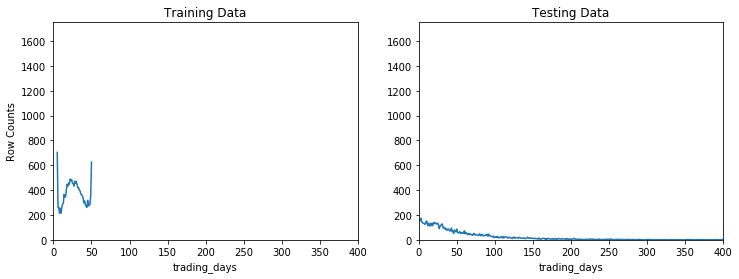

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Training Data")
train_df.groupby(by='trading_days').count()['ticker'].plot()
plt.ylabel("Row Counts")
plt.axis([0, 400, 0, 1750])

plt.subplot(1,2,2)
plt.title("Testing Data")
test_df.groupby(by='trading_days').count()['ticker'].plot()
plt.axis([0, 400, 0, 1750])

Taking this one step further, and let's split out the trades that earn money (gains), the trades that lose money (loss), and trades that make no money (zero). You can see that training split between gains and losses is almost 50/50. This is a bad thing and needs to be improved as the model may be learning the wrong signals. Furthermore, you can see that the losses in the test trades drop initially quicker than positive trades up to 40 trading days. After that the losses are slightly higher than gains.

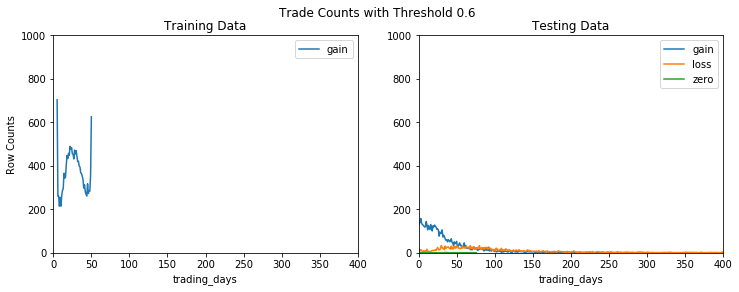

In [13]:
plt.figure(figsize=(12,4))

plt.suptitle("Trade Counts with Threshold 0.6")

plt.subplot(1,2,1)
train_df.loc[train_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].plot(label='gain')
#train_df.loc[train_df.gain_pct < 0].groupby(by='trading_days').count()['ticker'].plot(label='loss')
#train_df.loc[train_df.gain_pct == 0].groupby(by='trading_days').count()['ticker'].plot(label='zero')
plt.legend()
plt.axis([0, 400, 0, 1000])
plt.title("Training Data")
plt.ylabel("Row Counts")

plt.subplot(1,2,2)
test_df.loc[test_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].plot(label='gain')
test_df.loc[test_df.gain_pct < 0].groupby(by='trading_days').count()['ticker'].plot(label='loss')
test_df.loc[test_df.gain_pct == 0].groupby(by='trading_days').count()['ticker'].plot(label='zero')
plt.legend()
plt.axis([0, 400, 0, 1000])
plt.title("Testing Data")

plt.savefig("analysis_counts_06.png")

In [14]:
pos_df = test_df[['gain_pct', 'trading_days']].loc[test_df.gain_pct > 0].groupby(by='trading_days').count()
pos_df.columns = ['pos_counts']
loss_df = test_df[['gain_pct', 'trading_days']].loc[test_df.gain_pct < 0].groupby(by='trading_days').count()
loss_df.columns = ['neg_counts']
zero_df = test_df[['gain_pct', 'trading_days']].loc[test_df.gain_pct == 0].groupby(by='trading_days').count()
zero_df.columns = ['zero_counts']
temp = pd.concat([loss_df, pos_df, zero_df], join="outer").reset_index()
cols = [ 'pos_counts', 'neg_counts', 'zero_counts' ]
display(temp[cols].loc[temp.trading_days < 60].sum())
display(temp[cols].loc[temp.trading_days >= 60].sum())

/Users/frkornet/opt/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


pos_counts     5033.0
neg_counts     1063.0
zero_counts      30.0
dtype: float64

pos_counts     1350.0
neg_counts     2074.0
zero_counts       2.0
dtype: float64

In [15]:
# Function to calculate for each ticker symbol, the overall performance. The aim here is 
# to calculate the performance if you traded each possible trade for that ticker. 
# The overall daily return is calculated for the set of possible trades. This in turn
# is used in the cells below to determine a correlation between training and testing trades.
# The function prints each trade if verbose is set to True. 

def ticker_stats(df, ticker, verbose=False):
    if ticker != '*':
        tdf = df.loc[(df.ticker==ticker)]
    gains      = losses    = perf = 1.0
    gains_cnt  = loss_cnt  = 0
    gains_days = loss_days = days = 0
    gl = tdf.sort_values(by='buy_date').gain_pct
    dl = tdf.sort_values(by='buy_date').trading_days
    #print("gl=", gl)
    if verbose == True:
        print("Perf b4\t\tGains\t\tPerf\t\tGain Cnt   Gains\tLoss Cnt\tLosses  Days")
        print("=======\t\t=====\t\t====\t\t========   =====\t========\t======  ====")
    for g, d in zip(gl,dl):
        perfs = perf
        perf  = perf * (1.0 + g/100.0)
        days += d
        if g > 0:
            gains_cnt += 1
            gains_days += d
            gains = gains * (1.0 + g/100.0)
        else:
            loss_cnt  += 1
            loss_days += d
            losses = losses * (1.0 + g/100.0)
        
        if verbose == True:
            print(f"{perfs:.4f}\t\t{g:.3f}\t\t{perf:.4f}\t\t{gains_cnt:03d}\t   {gains:.4f}\t{loss_cnt:03d}\t\t{losses:.4f}  {d}")
        
    return perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses

In [16]:
# AAPL stats using train_df:
perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses = \
    ticker_stats(train_df, 'AAPL', verbose=True)
train_dret = (perf ** (1/days) - 1.0) * 100.0
print(f"\ntrain_dret={train_dret}")

Perf b4		Gains		Perf		Gain Cnt   Gains	Loss Cnt	Losses  Days
=======		=====		====		========   =====	========	======  ====
1.0000		14.190		1.1419		001	   1.1419	000		1.0000  21
1.1419		25.710		1.4355		002	   1.4355	000		1.0000  44
1.4355		22.110		1.7529		003	   1.7529	000		1.0000  44
1.7529		21.480		2.1294		004	   2.1294	000		1.0000  39
2.1294		17.880		2.5101		005	   2.5101	000		1.0000  36
2.5101		4.900		2.6331		006	   2.6331	000		1.0000  15
2.6331		14.730		3.0210		007	   3.0210	000		1.0000  42

train_dret=0.45980000283929456


In [17]:
# AAPL stats using test_df:
perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses = \
    ticker_stats(test_df, 'AAPL', verbose=True)
test_dret = (perf ** (1/days) - 1.0) * 100.0
print(f"\ntest_dret={test_dret}")

Perf b4		Gains		Perf		Gain Cnt   Gains	Loss Cnt	Losses  Days
=======		=====		====		========   =====	========	======  ====
1.0000		33.110		1.3311		001	   1.3311	000		1.0000  108
1.3311		-19.840		1.0670		001	   1.3311	001		0.8016  77
1.0670		33.530		1.4248		002	   1.7774	001		0.8016  110
1.4248		8.800		1.5502		003	   1.9338	001		0.8016  47

test_dret=0.12825681433712433


In [18]:
# Determine the unique set of ticker symbols. Determine the common symbols, the symbols missing in 
# testing, and the symbols missing in training.
#
train_tickers = set(train_df.ticker.unique())
test_tickers  = set(test_df.ticker.unique())
ctickers = train_tickers & test_tickers
print("Common tickers   :", len(ctickers))

missing_in_test_tickers = train_tickers - test_tickers
print("Missing in test  :", len(missing_in_test_tickers))

missing_in_train_tickers = test_tickers - train_tickers
print("Missing in train :", len(missing_in_train_tickers))

Common tickers   : 1990
Missing in test  : 195
Missing in train : 0


In [19]:
# Function that goes through the common train and test symbols, and for each symbol determine the
# overall daily return for train and test. These are then added to two separate lists. The function
# leverages the ticker_stats() function defined above. The function takes a while to run, as it has 
# over 2380 symbols to process. Can probably be done quicker using vectorized operations. Does work
# for now.

def calc_daily_returns_n_corr(train_df, test_df):
    train_daily_rets_l = []
    test_daily_rets_l  = []
    for i, t in enumerate(ctickers):

        perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses = ticker_stats(train_df, t)
        if days == 0.0:
            continue
        train_dret = (perf ** (1/days) - 1.0) * 100.0

        perf, days, gains_cnt, gains_days, gains, loss_cnt, loss_days, losses = ticker_stats(test_df, t)
        if days == 0.0:
            continue
        test_dret = (perf ** (1/days) - 1.0) * 100.0

        train_daily_rets_l.append(train_dret.real)
        test_daily_rets_l.append(test_dret.real)


    return train_daily_rets_l, test_daily_rets_l

The correlation between the train and test trades is calculated below. The correlation is 0.15. This is not much. It can be improved by eliminating the losses from training trades. Doing so, improves the correlation to 0.23. A bit better but not much. It should be noted that the inherent random walk of stock prices prevents us from ever getting a correlation of one. As a result, I would assume a correlation of 0.4 - 0.5 to be excellent.

The scatter plots for both sets of daily return is plotted below as well. They are side by side, so you can more easily compare them.

The correlation can be used as a measure to determine whether the different solutions are better or not. 

In [20]:
train_daily_rets, test_daily_rets = calc_daily_returns_n_corr(train_df, test_df)
corr = np.corrcoef(train_daily_rets, test_daily_rets )
print(corr)

[[ 1.         -0.00787628]
 [-0.00787628  1.        ]]


[[ 1.         -0.00787628]
 [-0.00787628  1.        ]]


Text(0.5, 1.0, 'Gains only')

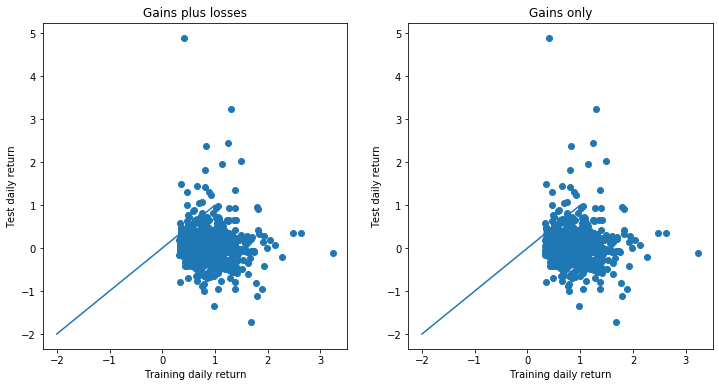

In [21]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(train_daily_rets, test_daily_rets)

x = [i/10 for i in range(-20, 11)]
y = [i/10 for i in range(-20, 11)]
plt.plot(x, y)

plt.xlabel("Training daily return")
plt.ylabel("Test daily return")
plt.title("Gains plus losses")

plt.subplot(1,2,2)
pos_xlist = []
pos_ylist = []
for xv, yv in zip(train_daily_rets, test_daily_rets):
    if xv > 0:
        pos_xlist.append(xv)
        pos_ylist.append(yv)

pcorr = np.corrcoef(pos_xlist, pos_ylist)
print(pcorr)

plt.scatter(pos_xlist, pos_ylist)
plt.plot(x, y)
plt.xlabel("Training daily return")
plt.ylabel("Test daily return")
plt.title("Gains only")


In [22]:
# Function to calculate the overall daily return of all trades
# for each specific number of trading days.
def plot_trading_days_vs_daily_return(df):
    days = list(np.sort(df.trading_days.unique()))

    gains = df[['gain_pct', 'trading_days']].copy()
    gains.gain_pct = 1+df.gain_pct/100.0

    td_df = gains[['trading_days', 'gain_pct']].groupby(by=df.trading_days).agg(['count', 'prod'])
    td = (td_df.index * td_df[('trading_days', 'count')])
    inv_td = 1/td

    drets = (td_df[('gain_pct',  'prod')] ** inv_td) - 1.0
    drets *= 100

    plt.plot(days, drets)


Using the function `plot_trading_days_vs_daily_return`, we can now plot the daily returns against the number of trading days for both train and test trades. For training data, you can see that the line moves up and down around the zero daily return line (red in the bottom two figures). This is due to the fact that losses and gains are about 50/50 split. Removing the losses should push the daily return line above the zero line.

For testing data, the pattern is entirely different, it starts off well above the zero daily return line (red) but drops below the zero line around 50 trading days and stays below the zero line after that. This seems to suggest that the losses outweigh the gains. It is unclear why the overall daily returns are above the zero line for the first 50 days. Note that if you are able to predict the number of trading days for the trade, you can reduce the chance of selecting losing trades. Before going there, the losses need to be removed from the training trades.

For more easy understanding the row counts for gains, losses, and no gains (zero) is shown in the top row of the four charts.

To put daily return in context. There are 200 trading days per year. The table shows what the annual return would be if the daily return is 0.1 - 0.4 percent. It is important to understand that the daily return compounds (i.e. it is an exponential function and not a linear one). 

| Daily Return | Annual Gain |
|--------------|-------------|
| 0.1%         | 22.1%       |
| 0.2%         | 49.1%       |
| 0.3%         | 82.0%       |
| 0.4%.        | 122.0%      |


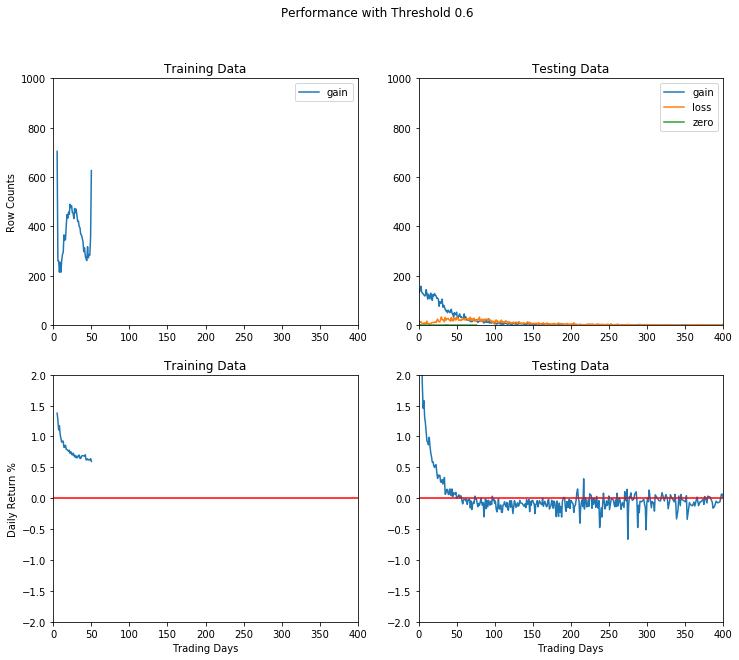

In [23]:
plt.figure(figsize=(12,10))

plt.suptitle("Performance with Threshold 0.6")
plt.subplot(2,2,1)
train_df.loc[train_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].plot(label='gain')
#train_df.loc[train_df.gain_pct < 0].groupby(by='trading_days').count()['ticker'].plot(label='loss')
#train_df.loc[train_df.gain_pct == 0].groupby(by='trading_days').count()['ticker'].plot(label='zero')
plt.legend()
plt.axis([0, 400, 0, 1000])
plt.title("Training Data")
plt.ylabel("Row Counts")
plt.xlabel("")

plt.subplot(2,2,2)
test_df.loc[test_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].plot(label='gain')
test_df.loc[test_df.gain_pct < 0].groupby(by='trading_days').count()['ticker'].plot(label='loss')
test_df.loc[test_df.gain_pct == 0].groupby(by='trading_days').count()['ticker'].plot(label='zero')
plt.legend()
plt.axis([0, 400, 0, 1000])
plt.title("Testing Data")
plt.xlabel("")

hx=[1, 400]
hy=[0, 0]

plt.subplot(2,2,3)
plt.title("Training Data")
plt.axis([0, 400, -2.0, 2.0])
plot_trading_days_vs_daily_return(train_df)
plt.xlabel("Trading Days")
plt.ylabel("Daily Return %")
plt.plot(hx, hy, color='red')

plt.subplot(2,2,4)
plt.title("Testing Data")
plt.axis([0, 400, -2.0, 2.0])
plot_trading_days_vs_daily_return(test_df)
plt.xlabel("Trading Days")
plt.plot(hx, hy, color='red')

plt.savefig("analysis_summary_06.png")

In [24]:
test_df.loc[test_df.trading_days < 60].sort_values(by='gain_pct').iloc[:1321]

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
5014,3.9714,2020-02-24,-3.32,-74.06,1.0300,2020-04-21,KOS,40
6402,0.6900,2020-02-21,-2.50,-69.57,0.2100,2020-04-29,OBELF,47
8485,3.9000,2019-10-21,-2.22,-67.44,1.2700,2020-01-02,TNXP,50
8484,15.3000,2019-06-20,-2.05,-67.32,5.0000,2019-09-06,TNXP,54
8961,12.7500,2020-02-24,-3.35,-66.35,4.2900,2020-04-08,VET,32
...,...,...,...,...,...,...,...,...
2403,21.1700,2018-09-24,0.03,1.37,21.4600,2018-11-30,CVBF,48
3361,16.8000,2020-07-01,0.04,1.37,17.0300,2020-08-14,FISI,31
618,11.7200,2020-05-12,0.23,1.37,11.8800,2020-05-20,APA,6
915,2.1308,2019-04-22,0.03,1.38,2.1601,2019-06-18,AUY,40


In [25]:
test_df.loc[test_df.trading_days >= 60].sort_values(by='gain_pct').iloc[:2191]

,buy_close,buy_date,daily_return,gain_pct,sell_close,sell_date,ticker,trading_days
1713,5937.5000,2018-11-06,-2.91,-99.97,2.05,2019-12-11,CEI,275
4855,3674.9976,2019-02-12,-1.33,-99.85,5.47,2021-01-14,JE,485
8995,2130.0000,2018-11-28,-1.80,-99.46,11.60,2020-01-23,VIVE,288
4606,232.2000,2018-08-24,-1.00,-99.29,1.64,2020-08-11,INPX,493
8000,812.8000,2019-08-01,-1.99,-98.34,13.50,2020-05-22,SRRA,204
...,...,...,...,...,...,...,...,...
5269,53.6600,2018-10-24,0.02,1.84,54.65,2019-02-11,LNC,73
7344,4.9000,2019-09-04,0.02,1.84,4.99,2019-12-19,RES,75
7611,15.6500,2018-03-23,0.02,1.85,15.94,2018-09-05,SBH,114
6889,30.5600,2019-05-31,0.03,1.90,31.14,2019-09-11,PKOH,71


In [26]:
max(train_df.trading_days)

50

In [31]:
tdlist = test_df.loc[test_df.gain_pct > 0].groupby(by='trading_days').count()['ticker'].index.tolist()

In [72]:
tdlist = test_df.groupby(by='trading_days').count()['ticker'].index.tolist()
p_tdlist = test_df.groupby(by='trading_days').count()['ticker']
som = sum(p_tdlist)
p_tdlist = np.array(p_tdlist / som)

tdays = np.random.choice(a=tdlist, size=1000, p=p_tdlist)
utd, utdc = np.unique(tdays, return_counts=True)

df_dict = { 'td': list(utd), 'cnt': list(utdc)}
utd_df = pd.DataFrame.from_dict(df_dict)
utd_df

,td,cnt
0,1,14
1,2,13
2,3,15
3,4,17
4,5,4
...,...,...
201,391,1
202,417,1
203,434,1
204,560,1
